In [33]:
import pandas as pd
from bs4 import BeautifulSoup
import requests
import yfinance as yf
import datetime as dt
import numpy as np
from concurrent.futures import ThreadPoolExecutor
import itertools
import datetime as dt

In [2]:
gDaysInYear = 365.0  # .242
gSmall = 1e-12
gNotebookMode = False

INVROOT2PI = 0.3989422804014327

In [3]:
def N(x):
    """ Fast Normal CDF function based on Hull OFAODS  4th Edition Page 252.
    This function is accurate to 6 decimal places. """

    a1 = 0.319381530
    a2 = -0.356563782
    a3 = 1.781477937
    a4 = -1.821255978
    a5 = 1.330274429
    g = 0.2316419

    k = 1.0 / (1.0 + g * np.abs(x))
    k2 = k * k
    k3 = k2 * k
    k4 = k3 * k
    k5 = k4 * k

    if x >= 0.0:
        c = (a1 * k + a2 * k2 + a3 * k3 + a4 * k4 + a5 * k5)
        phi = 1.0 - c * np.exp(-x*x/2.0) * INVROOT2PI
    else:
        phi = 1.0 - N(-x)

    return phi

In [4]:
def n_vect(x):
    return N(x)

In [5]:
def bs_delta(s, t, k, r, q, v, p_c):
    """ Price a derivative using Black-Scholes model. """

    if p_c == 'call':
        phi = +1.0
    elif p_c == 'put':
        phi = -1.0

    k = np.maximum(k, gSmall)
    t = np.maximum(t, gSmall)
    v = np.maximum(v, gSmall)

    vsqrtT = v * np.sqrt(t)
    ss = s * np.exp(-q*t)
    kk = k * np.exp(-r*t)
    d1 = np.log(ss/kk) / vsqrtT + vsqrtT / 2.0
    delta = phi * np.exp(-q*t) * n_vect(phi * d1)
    return delta

In [6]:
def exp_retrieve(name, thread_loop):
    
    try:
    
        tick = tickers.tickers[name]
        t_exp = pd.Series(tick.options, dtype=pd.StringDtype())
        
        t_loop = [x for x in itertools.product([tick], [name], t_exp)]
        
        thread_loop.extend(t_loop)
    
    except:
        
        pass

In [68]:
def option_retrieve(tick, name, exp):
    
    try:
    
        t_book = tick.option_chain(exp)
        t_calls = t_book.calls
        t_puts = t_book.puts
        
        t_calls['callput'] = 'call'
        t_puts['callput'] = 'put'
        
        t_chain = pd.concat([t_calls, t_puts])
        
        t_chain['expiry'] = exp
        t_chain['ticker'] = name
        t_chain['stock_px'] = px['Adj Close'][name].iloc[-1]
        t_chain['stock_ret'] = rets['Adj Close'][name].iloc[-1]
        
        t_chain.reset_index(drop=True, inplace=True)
        
    except:
        
        t_chain = pd.DataFrame()
    
    return t_chain

In [134]:
def get_delta_values(df):
    
    df_delta = df.copy()
    
    today_array = [dt.date.today().strftime('%Y-%m-%d')] * len(df_delta.index)
    df_delta['k_norm'] = df_delta['strike'] / df_delta['stock_px']
    df_delta['1d_delta'] = df_delta['change'] / 100 / df_delta['stock_ret']
    df_delta['t_exp'] = np.busday_count(today_array, [x for x in df_delta['expiry']])
    
    df_delta['delta_calc'] = df_delta.apply(lambda x: bs_delta(x.stock_px, x.t_exp/252, x.strike, 0, 0, x.impliedVolatility, x.callput), axis = 1)
    
    return df_delta

In [8]:
html = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
soup = BeautifulSoup(html.text, 'lxml')
table = soup.find('table', {'class': 'wikitable sortable'})

In [9]:
stock_data = pd.read_html(str(table))[0]

In [10]:
delta_t = pd.tseries.offsets.BusinessDay(n = 21)
end_date = dt.date.today()
start_date = end_date - delta_t

In [11]:
names = [name.replace(".", "-") for name in stock_data.Symbol]
name_query = " ".join(names)

In [12]:
px = yf.download(name_query, start=start_date)
rets = px.pct_change(1)

[*********************100%***********************]  503 of 503 completed


In [17]:
tickers = yf.Tickers(name_query)

In [137]:
thread_count = 25
name_count = len(names)

thread_loop = []

with ThreadPoolExecutor(thread_count) as executor:
    futures = [executor.submit(exp_retrieve, name, thread_loop) for name in names[:name_count]]
    
with ThreadPoolExecutor(thread_count) as executor:
    futures = [executor.submit(option_retrieve, tick, name, exp) for tick, name, exp in thread_loop]
    
opt_chain = pd.concat([future.result() for future in futures]).sort_values(['ticker', 'expiry']).reset_index(drop = True)

/var/folders/k2/d2y9gjxs0jz7tm_dt0tv243m0000gn/T/ipykernel_52469/2570180908.py:12: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  t_chain = pd.concat([t_calls, t_puts])
/var/folders/k2/d2y9gjxs0jz7tm_dt0tv243m0000gn/T/ipykernel_52469/2570180908.py:12: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  t_chain = pd.concat([t_calls, t_puts])
/var/folders/k2/d2y9gjxs0jz7tm_dt0tv243m0000gn/T/ipykernel_52469/2570180908.py:12: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these wil

In [138]:
cleaned_chain = get_delta_values(opt_chain)

In [139]:
cleaned_chain

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,...,currency,callput,expiry,ticker,stock_px,stock_ret,k_norm,1d_delta,t_exp,delta_calc
0,A230120C00060000,2021-11-10 11:48:04+00:00,60.0,67.00,94.6,99.4,0.0,0.0,2.0,2.0,...,USD,call,2023-01-20,A,147.669998,-0.029189,0.406311,-0.0,9,0.915723
1,A230120C00075000,2022-07-22 17:59:00+00:00,75.0,51.44,58.2,60.0,0.0,0.0,2.0,0.0,...,USD,call,2023-01-20,A,147.669998,-0.029189,0.507889,-0.0,9,1.000000
2,A230120C00080000,2022-07-06 16:22:04+00:00,80.0,43.57,54.8,58.4,0.0,0.0,3.0,17.0,...,USD,call,2023-01-20,A,147.669998,-0.029189,0.541748,-0.0,9,1.000000
3,A230120C00085000,2021-11-16 15:10:37+00:00,85.0,77.60,68.5,72.5,0.0,0.0,5.0,6.0,...,USD,call,2023-01-20,A,147.669998,-0.029189,0.575608,-0.0,9,0.875412
4,A230120C00090000,2021-11-10 11:48:04+00:00,90.0,49.10,64.6,69.4,0.0,0.0,1.0,6.0,...,USD,call,2023-01-20,A,147.669998,-0.029189,0.609467,-0.0,9,0.857656
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74804,ZTS240119P00210000,2021-11-04 19:23:18+00:00,210.0,31.57,26.8,31.5,0.0,0.0,NaN,6.0,...,USD,put,2024-01-19,ZTS,147.639999,0.015057,1.422379,0.0,269,-1.000000
74805,ZTS240119P00220000,2021-12-27 15:18:46+00:00,220.0,23.30,30.0,34.4,0.0,0.0,NaN,1.0,...,USD,put,2024-01-19,ZTS,147.639999,0.015057,1.490111,0.0,269,-1.000000
74806,ZTS240119P00230000,2021-12-13 05:02:25+00:00,230.0,35.00,35.5,39.5,0.0,0.0,NaN,1.0,...,USD,put,2024-01-19,ZTS,147.639999,0.015057,1.557843,0.0,269,-1.000000
74807,ZTS240119P00260000,2022-07-15 15:38:29+00:00,260.0,87.25,84.5,89.5,0.0,0.0,NaN,0.0,...,USD,put,2024-01-19,ZTS,147.639999,0.015057,1.761040,0.0,269,-1.000000


In [140]:
ticks = [name for name in cleaned_chain.groupby('ticker')['volume'].sum().sort_values(ascending=False)[:20].index]

In [141]:
rebase_index = np.arange(0.75,1.26,0.01)
smaller_index = np.arange(0.9,1.11,0.01)

In [146]:
d_curve = cleaned_chain[(cleaned_chain['ticker'].isin(ticks)) & (cleaned_chain['expiry'] == '2023-01-20') & (cleaned_chain['callput'] == 'call')]

In [147]:
curves = pd.DataFrame()

curve_df = pd.DataFrame(columns = ticks, index = rebase_index)

for tick in ticks:
    
    t_curve = d_curve[d_curve['ticker'] == tick][['k_norm', 'delta_calc']].set_index('k_norm')

    interp_curve = pd.DataFrame(np.interp(rebase_index, t_curve.index, t_curve.delta_calc), index = rebase_index)

    curve_df[tick] = interp_curve

<AxesSubplot: >

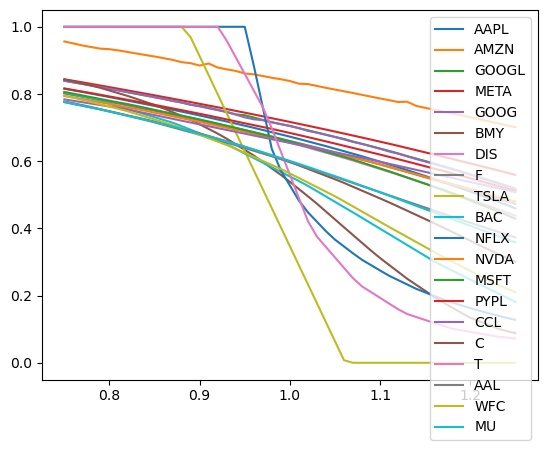

In [148]:
curve_df.plot()